In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression , Ridge, Lasso, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, datasets
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
from glm.glm import GLM
from glm.families import Gaussian
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import re
from clean import *
from sklearn.ensemble import RandomForestRegressor
from rfpimp import *  # feature importance plot

In [223]:
def sniff(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['sample'] = df.iloc[0]
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        return info.sort_values('data type')


In [224]:
test_data = pd.read_csv('data/test.csv')

train_data = pd.read_csv('data/Train.csv')

/home/richard/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [225]:
import feather
df_raw = feather.read_dataframe("data/bulldozer-train.feather")
df = df_raw.copy()

In [226]:
sniff(df)

,sample,data type,percent missing
SalesID,1646770,int64,0.000000
SalePrice,9500,int64,0.000000
MachineID,1126363,int64,0.000000
ModelID,8434,int64,0.000000
datasource,132,int64,0.000000
YearMade,1974,int64,0.000000
auctioneerID,18,float64,5.174687
MachineHoursCurrentMeter,NaN,float64,64.717764
saledate,1989-01-17 00:00:00,datetime64[ns],0.000000
Coupler,None,object,46.826855


In [144]:
base_features = list(sniff(df).index[:8])# only use features that don't require cleaning
base_features.remove('SalePrice') #remove saleprice

In [42]:
base_features

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'YearMade',
 'auctioneerID',
 'MachineHoursCurrentMeter']

In [146]:
def test(X, y, n_estimators=50): #reusing test function from the NYC rent model
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 {oob:.5f} using {n:,d} tree nodes with {h} median tree height")
    return rf, oob

def rmsle(actual, predictions):
    log_diff = np.log(predictions+1) - np.log(actual+1)
    return np.sqrt(np.mean(log_diff**2))

def score_test(X_train, y_train, X_test, n_estimators=50): #using score model
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    predictions = rf.predict(X_test)
    actual = pd.read_csv('data/do_not_open/test_soln.csv')
    rmsle(predictions, actual['SalePrice'])

In [147]:
X, y = df[base_features], df['SalePrice']
X = X.fillna(0) # set all NaN values to zeroes as baseline
rf, oob_baseline_initial = test(X,y)

OOB R^2 0.78126 using 22,495,682 tree nodes with 54.0 median tree height


In [97]:
predictions = rf.predict(test_data[base_features].fillna(0))
rmsle(predictions, actual['SalePrice']) #baseline rmsle

0.3772509222115594

In [148]:
df = df.iloc[-100000:] #only use 100000 most recent records, might have more prediction value
#                       and speed up training time


In [149]:
X, y = df[base_features], df['SalePrice']
X = X.fillna(0)
rf, oob_baseline_initial = test(X,y)
# looks like the R2 actually got better

OOB R^2 0.84585 using 5,559,094 tree nodes with 46.0 median tree height


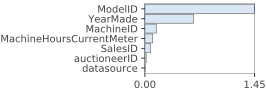

In [106]:
I = importances(rf, X, y)
plot_importances(I)

In [150]:
df['auctioneerID'].unique()
df['auctioneerID'] = df['auctioneerID'].astype(str) #make this into categorical variable

In [156]:
del df['MachineID'] # delete both of these according to Kaggle QA control discussion
del df['SalesID']

,SalesID,SalePrice,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
289125,2333443,8300,4663,136,nan,1985,0.0,None,2009-01-23,450D,...,None,None,None,None,None,None or Unspecified,PAT,None or Unspecified,None,None
289126,1720071,15500,11859,132,5.0,1995,NaN,None,2009-01-23,SK120,...,None or Unspecified,None or Unspecified,Manual,None or Unspecified,Double,None,None,None,None,None
289127,2257752,26000,1133,136,5.0,1997,0.0,None,2009-01-23,315L,...,None or Unspecified,None or Unspecified,Hydraulic,None or Unspecified,Triple,None,None,None,None,None
289128,2402279,80000,457,136,5.0,1993,0.0,None,2009-01-23,PC300LC5,...,36 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,None,None,None,None,None
289129,2235640,77500,3858,136,5.0,2000,0.0,None,2009-01-23,966G,...,None,None,None,None,None,None,None,None,Standard,Conventional
289130,2327730,17750,4584,136,2.0,1999,0.0,None,2009-01-23,244H,...,None,None,None,None,None,None,None,None,Standard,Conventional
289131,1742194,49000,2249,132,5.0,2005,NaN,None,2009-01-23,PC228USLC,...,24 inch,None or Unspecified,None or Unspecified,None or Unspecified,Triple,None,None,None,None,None
289132,2314238,14000,3409,136,5.0,2005,0.0,None,2009-01-23,226B,...,None,None,None,None,None,None,None,None,None,None
289133,1722460,53000,2140,132,5.0,2005,NaN,None,2009-01-23,SK160LC,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,None,None,None,None,None
289134,2277585,16750,2758,136,2.0,1998,0.0,None,2009-01-23,D5CIII,...,None,None,None,None,None,None or Unspecified,PAT,None or Unspecified,None,None


In [157]:
# normalize all the columns for none values into nan rather than str

from pandas.api.types import is_string_dtype, is_object_dtype
def df_normalize_strings(df):
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan) # make None -> np.nan
            df[col] = df[col].replace('none or unspecified', np.nan)
            df[col] = df[col].replace('none', np.nan)
            df[col] = df[col].replace('#name?', np.nan)
            df[col] = df[col].replace('', np.nan)

df_normalize_strings(df)

In [113]:
# convert numerical str to float/int
def extract_sizes(df, colname):
    df[colname] = df[colname].str.extract(r'([0-9.]*)', expand=True) #finds only digits and replaces it in column
    df[colname] = df[colname].replace('', np.nan) #converts blanks into nan
    df[colname] = pd.to_numeric(df[colname])


In [158]:
extract_sizes(df, 'Tire_Size')
extract_sizes(df, 'Undercarriage_Pad_Width')


In [115]:
# convert str to categories, nan needs to go from -1 to 0

from pandas.api.types import is_categorical_dtype
def df_string_to_cat(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()

def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [159]:
df_string_to_cat(df)
df_cat_to_catcode(df)

In [119]:
# New column for each of the rows to indicate if there are missing values or not for the entry
def fix_missing_num(df, colname):
    df[colname+'_na'] = pd.isnull(df[colname])
    df[colname].fillna(df[colname].median(), inplace=True)
# New column should add some predictability as unknown information generally lowers sale price

In [160]:
fix_missing_num(df, 'Tire_Size')
fix_missing_num(df, 'Undercarriage_Pad_Width')


In [127]:
df.YearMade.unique()
# lots of 1000 values, need to convert those to NaN, same with 1919 and 1920


array([1985, 1995, 1997, 1993, 2000, 1999, 2005, 1998, 1000, 2003, 1996,
       2001, 2004, 1977, 2002, 1987, 2006, 1994, 1990, 2008, 2007, 1984,
       1992, 1982, 1974, 1988, 1989, 1973, 1978, 1967, 1986, 1980, 1966,
       1979, 1975, 1971, 1991, 1969, 1981, 1968, 1964, 1983, 1972, 1965,
       1962, 1970, 1976, 1963, 1960, 1961, 1951, 1948, 1959, 2009, 1953,
       1920, 2012, 2010, 1919, 1952, 1954, 1956, 2011])

In [161]:
df.loc[df.YearMade<1950, 'YearMade'] = np.nan
fix_missing_num(df, 'YearMade')


In [162]:
#problems with sale date being after year made. Probably clerical error and need to reverse

df.loc[df.eval("saledate.dt.year < YearMade"), 'YearMade'] = df['saledate'].dt.year

In [163]:
df.loc[df.eval("MachineHoursCurrentMeter==0"),
       'MachineHoursCurrentMeter'] = np.nan
fix_missing_num(df, 'MachineHoursCurrentMeter')

In [164]:
X, y = df.drop(['SalePrice','saledate'], axis=1), df['SalePrice']

rf, oob_all = test(X, y)


OOB R^2 0.89880 using 5,355,520 tree nodes with 44.0 median tree height


In [165]:
df = df.reset_index(drop=True)
df.to_feather("data/bulldozer-train-clean.feather")

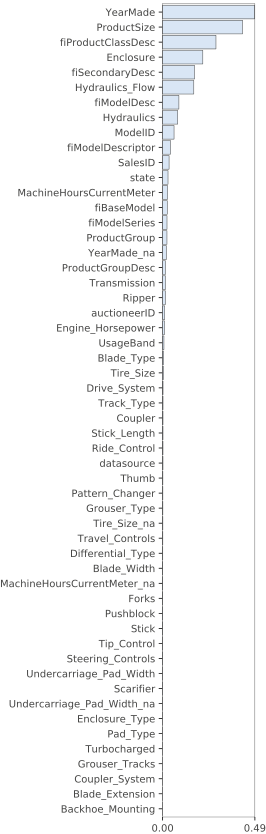

In [168]:
I = importances(rf, X, y)
plot_importances(I)

In [174]:
df_raw = feather.read_dataframe("data/bulldozer-train.feather")
df_raw = df_raw.iloc[-100_000:] # same 100,000 records as before
df = feather.read_dataframe("data/bulldozer-train-clean.feather")

In [175]:
X, y = df.drop(['SalePrice','saledate'], axis=1), df['SalePrice']
rf, oob_clean = test(X, y, n_estimators=150)

OOB R^2 0.90260 using 16,073,288 tree nodes with 44.0 median tree height


In [176]:
# maybe date will have predictive value

def df_split_dates(df,colname):
    df["saleyear"] = df[colname].dt.year
    df["salemonth"] = df[colname].dt.month
    df["saleday"] = df[colname].dt.day
    df["saledayofweek"] = df[colname].dt.dayofweek
    df["saledayofyear"] = df[colname].dt.dayofyear
    df[colname] = df[colname].astype(np.int64) # convert to seconds since 1970

In [177]:
df_split_dates(df, 'saledate')
df.filter(regex=('sale*')).head(2).T

,0,1
saledate,1232668800000000000,1232668800000000000
saleyear,2009,2009
salemonth,1,1
saleday,23,23
saledayofweek,4,4
saledayofyear,23,23


In [178]:
X, y = df.drop('SalePrice', axis=1), df['SalePrice']
rf, oob_dates = test(X, y, n_estimators=150)
# r2 got better

OOB R^2 0.91228 using 15,206,020 tree nodes with 43.0 median tree height


In [179]:
# create an age column

df['age'] = df['saleyear'] - df['YearMade']

X, y = df.drop('SalePrice', axis=1), df['SalePrice']
rf, oob_age = test(X, y, n_estimators=150)

OOB R^2 0.91150 using 15,184,710 tree nodes with 43.0 median tree height


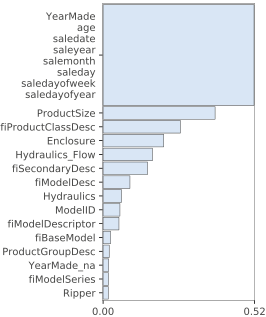

In [180]:
# no improvement, age and sale price probably are sharing predictability
# remove some date features
features = list(df.drop('SalePrice',axis=1).columns)
datefeatures = list(df.filter(regex=("sale*")).columns)
for f in datefeatures:
    features.remove(f)
features.remove('YearMade')
features.remove('age')
features += [['YearMade','age']+datefeatures]
I = importances(rf, X, y, features=features)
plot_importances(I.head(15))


Text(0.5, 0, 'Age in years')

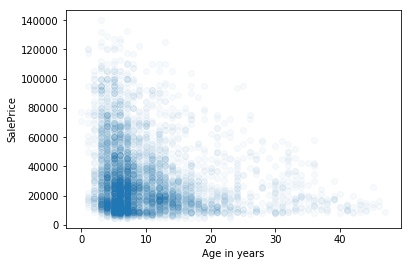

In [182]:
# try to see if there is a relationship between age and sale price

fig,ax = plt.subplots()
df_small = df.sample(n=5_000) # don't draw too many dots
ax.scatter(df_small['age'], df_small['SalePrice'],
           alpha=0.03)
ax.set_ylabel("SalePrice")
ax.set_xlabel("Age in years")



## looks like there may be a relationship

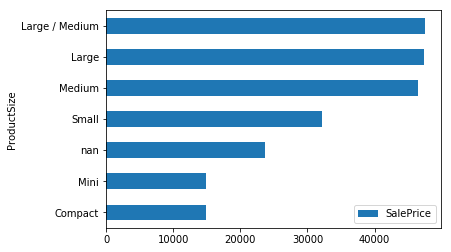

In [185]:
# try and categorize product sizes

temp = df_raw.fillna('nan') # original dataset
temp = temp.groupby('ProductSize').mean()
temp[['SalePrice']].sort_values('SalePrice').plot.barh()



In [186]:
sizes = {None:0, 'Mini':1, 'Compact':1, 'Small':2, 'Medium':3,
         'Large / Medium':4, 'Large':5}
df['ProductSize'] = df_raw['ProductSize'].map(sizes).values


[0 2 4 3 1 5]


In [187]:
X, y = df.drop('SalePrice', axis=1), df['SalePrice']
rf, oob_ProductSize = test(X, y, n_estimators=150)
# slight increase in r2

OOB R^2 0.91450 using 15,158,710 tree nodes with 46.0 median tree height


In [188]:
# get dummy variables for hydraulics flow
# change none to nans

df['Hydraulics_Flow'] = df_raw['Hydraulics_Flow'].values
df['Hydraulics_Flow'] = df['Hydraulics_Flow'].replace('None or Unspecified', np.nan)
onehot = pd.get_dummies(df['Hydraulics_Flow'],
                        prefix='Hydraulics_Flow',
                        dtype=bool)

In [190]:
onehot.head()

,Hydraulics_Flow_High Flow,Hydraulics_Flow_Standard
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [191]:
del df['Hydraulics_Flow']
df = pd.concat([df, onehot], axis=1) #attach it to our df

In [192]:
X, y = df.drop('SalePrice', axis=1), df['SalePrice']
rf, oob_Hydraulics_Flow = test(X, y, n_estimators=150)
# similar performance

OOB R^2 0.91391 using 15,153,460 tree nodes with 46.0 median tree height


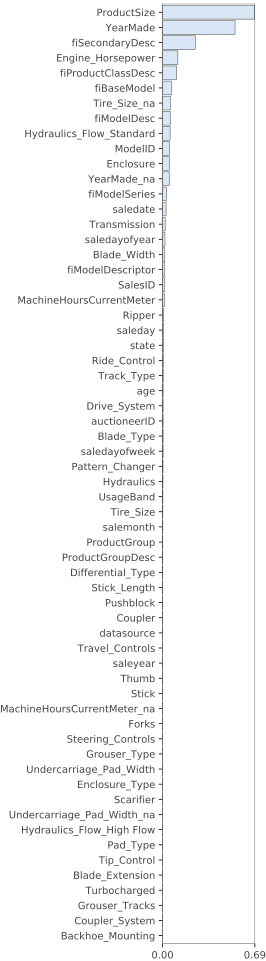

In [193]:
I = importances(rf, X, y)
plot_importances(I) #hydralic flow standard looks like it has some predictive values

In [194]:
df['Enclosure'] = df_raw['Enclosure'].values
df['Enclosure'] = df['Enclosure'].replace('EROPS w AC', 'EROPS AC')
df['Enclosure'] = df['Enclosure'].replace('None or Unspecified', np.nan)
df['Enclosure'] = df['Enclosure'].replace('NO ROPS', np.nan)


In [196]:
# try to categorize enclosure too
onehot = pd.get_dummies(df['Enclosure'],
                        prefix='Enclosure',
                        dtype=bool)
del df['Enclosure']
df = pd.concat([df, onehot], axis=1)
X, y = df.drop('SalePrice', axis=1), df['SalePrice']
rf, oob_Enclosure = test(X, y, n_estimators=150)
# doesnt improve

OOB R^2 0.91269 using 15,185,672 tree nodes with 44.0 median tree height


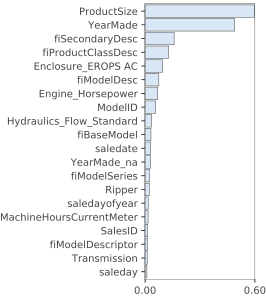

In [200]:
I = importances(rf, X, y)
plot_importances(I.head(20)) # enclosure seems like it has predictive value as well

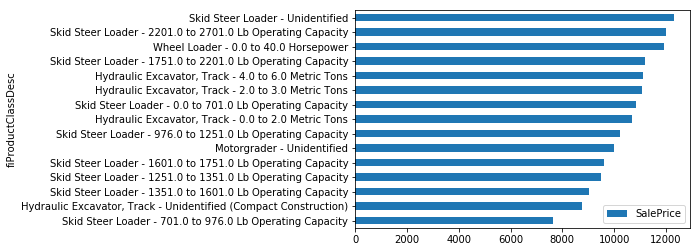

In [198]:
# class description might have some value

temp = df_raw.groupby('fiProductClassDesc').mean()
temp[['SalePrice']].sort_values('SalePrice').head(15).plot.barh()


In [204]:
# split descriptions, left side = bulldozer class and right side = HP/ operating capacitiy

df_split = df_raw.fiProductClassDesc.str.split(' - ',expand=True).values
df['fiProductClassDesc'] = df_split[:,0] 
df['fiProductClassSpec'] = df_split[:,1] # temporary column
print(df['fiProductClassDesc'].unique())
print(df['fiProductClassSpec'].unique()[:5])


['Track Type Tractor, Dozer' 'Hydraulic Excavator, Track' 'Wheel Loader'
 'Skid Steer Loader' 'Backhoe Loader' 'Motorgrader']
['20.0 to 75.0 Horsepower' '12.0 to 14.0 Metric Tons'
 '14.0 to 16.0 Metric Tons' '33.0 to 40.0 Metric Tons'
 '225.0 to 250.0 Horsepower']


In [216]:
# split the right side string into categories for lower to upper bound, and then unit
pattern = r'([0-9.\+]*)(?: to ([0-9.\+]*)|\+) ([a-zA-Z ]*)'
df_split = df['fiProductClassSpec'].str.extract(pattern, expand=True).values
df['fiProductClassSpec_lower'] = pd.to_numeric(df_split[:,0]) #lower bound
df['fiProductClassSpec_upper'] = pd.to_numeric(df_split[:,1]) #upper bound
df['fiProductClassSpec_units'] = df_split[:,2] #unit
del df['fiProductClassSpec'] # remove temporary column
df.filter(regex=('fiProductClassSpec*')).head(3)


,fiProductClassSpec_lower,fiProductClassSpec_upper,fiProductClassSpec_units
0,20.0,75.0,Horsepower
1,12.0,14.0,Metric Tons
2,14.0,16.0,Metric Tons


In [217]:
fix_missing_num(df, 'fiProductClassSpec_lower')
fix_missing_num(df, 'fiProductClassSpec_upper')
# label encode fiProductClassDesc fiProductClassSpec_units
df_string_to_cat(df)
df_cat_to_catcode(df) #convert to categorical 

In [218]:
X, y = df.drop('SalePrice', axis=1), df['SalePrice']
rf, oob_fiProductClassDesc = test(X, y, n_estimators=150)
# model didn't improve

OOB R^2 0.91291 using 15,161,038 tree nodes with 44.0 median tree height


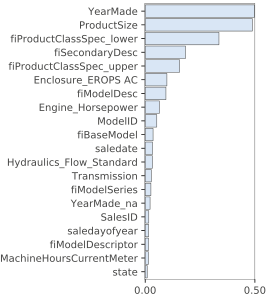

In [219]:
I = importances(rf, X, y)
plot_importances(I.head(20))
# product class looks like it has value though

In [220]:
#try logging y

X, y = df.drop('SalePrice', axis=1), df['SalePrice']
y = np.log(y)
rf, oob_log = test(X, y, n_estimators=150)

# significant improvement

OOB R^2 0.91728 using 15,155,652 tree nodes with 45.0 median tree height


In [221]:
#train and validate

from sklearn.model_selection import train_test_split
df = df.sample(frac=1) # shuffle data
df_dev, df_test = train_test_split(df, test_size=0.15)
df_train, df_valid = train_test_split(df_dev, test_size=0.15)

from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(...)
scores = cross_val_score(rf, X, y, cv=5) # k=5
print(scores.mean())


/home/richard/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: n_estimators must be an integer, got <class 'ellipsis'>.